# Notebook 1: data_preparation.ipynb

Este cuaderno tiene como objetivo preparar los datos espaciales requeridos para realizar análisis del departamento Valle del Cauca.
A lo largo de este cuaderno realizaremos las siguientes tareas: 
-Carga de capas vectoriales (shapefiles).
-Recorte y reproyección al sistema de referencia oficial MAGNA-SIRGAS (EPSG:3116).
-Validación de coberturas para análisis espacial posteriores.
Las capas utilizadas representan aspectos del territorio: vías, curvas de nivel, pendientes, cobertura del suelo, áreas protegidas e hidrografía.

Este notebook realiza la preparación inicial de los datos espaciales necesarios para el análisis multicriterio. Incluye:

- **Carga de capas vectoriales** (shapefiles) y ráster usando `geopandas` y `rasterio`.
- **Exploración y validación** de proyecciones, geometrías y metadatos.
- **Recorte espacial** de datos al área de estudio para garantizar consistencia espacial.
- **Reproyección** de capas a un sistema de referencia común (CRS).
- **Exportación** de archivos intermedios ya limpios para su uso posterior en análisis.

Este paso es fundamental para asegurar que todas las capas estén listas y alineadas antes de aplicar los criterios de priorización.

# 1. Cargue de librerias 
En esta sección se importan las principales librerías para visualizar y analizar datos geoespaciales, así como las funciones desarrolladas en el módulo src/data_preparation.py que centralizan la preparación y procesamiento de datos espaciales.

***El objetivo es mantener un flujo de trabajo organizado y reproducible, donde la lógica de preparación de datos se encuentra separada en scripts reutilizables y el notebook se enfoca en la exploración de datos.***

A continuación importamos el *stack* principal para preparación de datos espaciales y configuramos estilos globales:

- **geopandas** – lectura, edición y escritura de GeoDataFrames (datos vectoriales con geometrías).
- **pandas** – manejo de tablas y atributos no espaciales.
- **matplotlib.pyplot** – graficación básica de geometrías y atributos.
- **contextily** – adición de *tiles* de mapas base (Web Mercator) a nuestros gráficos.
- **os** – operaciones con el sistema de archivos (rutas, creación de carpetas).

In [3]:
# Acceso a las funciones propias 
import sys
sys.path.append('../src')

# Importar funciones
from data_processing import (
    construir_rutas_capas, 
    leer_shapefile,
  
)

# Importar librerías para visualización/análisis en el notebook
import matplotlib.pyplot as plt
import contextily as ctx   
import pandas as pd       

## 2. Delimitación de los límites del Valle del Cauca, teniendo en cuenta que ya se tenía la capa de los municipios de Colombia

Para definir el límite departamental del Valle del Cauca, utilizamos los datos de una capa nacional de municipios de Colombia. Ahora, este procedimiento ha sido **modularizado**: toda la lógica de carga, filtrado, disolución y almacenamiento está centralizada en funciones personalizadas ubicadas en `src/data_processing.py`. Esto permite mantener un flujo de trabajo más limpio, reproducible y reutilizable.

**El proceso incluye los siguientes pasos, ejecutados de forma modular:**

1. **Carga y procesamiento automatizado:**  
   La función `leer_limite_valle()` recibe la ruta al shapefile nacional de municipios, filtra por el departamento correspondiente (`DPTO_CCDGO == '76'`), realiza la disolución de los límites municipales para obtener un único polígono departamental y retorna el resultado como un GeoDataFrame.

2. **Exploración de atributos (opcional):**  
   Si es necesario, pueden explorarse los atributos o columnas originales del shapefile nacional antes de llamar a la función modularizada, por ejemplo usando `print(gdf_mun.columns)`.

3. **Creación automática de carpeta destino:**  
   La función `guardar_shapefile()` se encarga de asegurar que la carpeta donde se almacenará el shapefile resultante exista, utilizando `os.makedirs` en su interior.

> De esta manera, el flujo se automatiza y puede ser fácilmente replicado para otros departamentos o capas simplemente cambiando los parámetros de entrada en las funciones.

In [4]:
#2. Definición de límites de Valle del Cauca
import sys
sys.path.append('../src')
from data_processing import leer_limite_valle, guardar_shapefile

ruta_municipios = "../../Workshop_6/datos_colombia/municipios_colombia.shp"
limite_valle_gdf = leer_limite_valle(ruta_municipios)

if 'AREA' in limite_valle_gdf.columns:
    limite_valle_gdf = limite_valle_gdf.drop(columns=['AREA'])

guardar_shapefile(limite_valle_gdf, "../data/limites/limite_valle.shp")


## 3. Definición de rutas a capas temáticas

En esta sección se definen las rutas completas a los distintos archivos shapefile (`.shp`) que contienen la información geoespacial necesaria para el análisis territorial en el departamento del Valle del Cauca. 

Para una mejor organización y flexibilidad del proyecto, la construcción dinámica de rutas ha sido **modularizada** mediante la función `construir_rutas_capas()` ubicada en `src/data_processing.py`. Esta función permite centralizar y automatizar la generación de rutas, facilitando su actualización y reutilización a lo largo del proyecto.

La función combina los siguientes elementos:
- **`data_dir`**: Ruta base donde se encuentran almacenados todos los datos espaciales.
- **Subcarpetas temáticas**: Directorios específicos para cada tipo de capa.
- **Nombre del archivo shapefile** correspondiente a cada tema.

A continuación se describen las capas utilizadas:

- **`limite_valle`**: Límite departamental del Valle del Cauca. Esta capa actúa como **máscara espacial** para recortar todas las demás capas a la extensión del área de estudio.
- **`vias`**: Red vial del departamento, que incluye carreteras, caminos y otras infraestructuras de transporte terrestre.
- **`areas_protegidas`**: Polígonos que representan zonas con alguna figura de protección ambiental o legal (reservas naturales, parques).
- **`curvas_nivel`**: Líneas de contorno que representan la **elevación** del terreno, utilizadas para análisis de relieve y altimetría.
- **`pendientes`**: Información derivada del modelo de elevación que representa la **inclinación del terreno**, útil para evaluar restricciones físicas del suelo.
- **`suelo`**: Muestra los tipos de cobertura o uso del suelo (como cultivos, bosques, áreas urbanas, entre otros).
- **`hidrografia`**: Red hidrográfica que incluye ríos, quebradas, humedales y demás cuerpos de agua superficiales.

> De esta manera, cualquier cambio en las rutas o nombres de archivos puede hacerse fácilmente en la función central, y el resto del código permanece limpio y fácil de mantener.


In [8]:
import sys
sys.path.append('../src')
from data_processing import construir_rutas_capas, leer_shapefile

# Construcción centralizada de rutas
rutas = construir_rutas_capas()

# Cargar capas principales
valle = leer_shapefile(rutas["limite_valle"])
vias = leer_shapefile(rutas["vias"])
areas_protegidas = leer_shapefile(rutas["areas_protegidas"])
curvas_nivel = leer_shapefile(rutas["curvas_nivel"])
pendientes = leer_shapefile(rutas["pendientes"])
suelo = leer_shapefile(rutas["suelo"])
hidrografia = leer_shapefile(rutas["hidrografia"])

# Descripción básica de las capas cargadas 
capas = {
    "Límite Valle": valle,
    "Vías": vias,
    "Áreas Protegidas": areas_protegidas,
    "Curvas de Nivel": curvas_nivel,
    "Pendientes": pendientes,
    "Suelo": suelo,
    "Hidrografía": hidrografia
}

for nombre, gdf in capas.items():
    print(f"\n--- {nombre} ---")
    print(f"CRS: {gdf.crs}")
    print(f"Geometrías: {len(gdf)}")
    print(f"Tipo de geometría: {gdf.geom_type.unique()}")
    print(f"Columnas: {list(gdf.columns)}")


--- Límite Valle ---
CRS: EPSG:3116
Geometrías: 1
Tipo de geometría: ['MultiPolygon']
Columnas: ['DPTO_CCDGO', 'MPIO_CCDGO', 'MPIO_CNMBR', 'MPIO_CDPMP', 'VERSION', 'LATITUD', 'LONGITUD', 'STCTNENCUE', 'STP3_1_SI', 'STP3_2_NO', 'STP3A_RI', 'STP3B_TCN', 'STP4_1_SI', 'STP4_2_NO', 'STP9_1_USO', 'STP9_2_USO', 'STP9_3_USO', 'STP9_4_USO', 'STP9_2_1_M', 'STP9_2_2_M', 'STP9_2_3_M', 'STP9_2_4_M', 'STP9_2_9_M', 'STP9_3_1_N', 'STP9_3_2_N', 'STP9_3_3_N', 'STP9_3_4_N', 'STP9_3_5_N', 'STP9_3_6_N', 'STP9_3_7_N', 'STP9_3_8_N', 'STP9_3_9_N', 'STP9_3_10', 'STP9_3_99', 'STVIVIENDA', 'STP14_1_TI', 'STP14_2_TI', 'STP14_3_TI', 'STP14_4_TI', 'STP14_5_TI', 'STP14_6_TI', 'STP15_1_OC', 'STP15_2_OC', 'STP15_3_OC', 'STP15_4_OC', 'TSP16_HOG', 'STP19_EC_1', 'STP19_ES_2', 'STP19_EE_1', 'STP19_EE_2', 'STP19_EE_3', 'STP19_EE_4', 'STP19_EE_5', 'STP19_EE_6', 'STP19_EE_9', 'STP19_ACU1', 'STP19_ACU2', 'STP19_ALC1', 'STP19_ALC2', 'STP19_GAS1', 'STP19_GAS2', 'STP19_GAS9', 'STP19_REC1', 'STP19_REC2', 'STP19_INT1', 'STP19_INT

## 4. Recorte y Reproyección de Capas Temáticas

Para realizar análisis espaciales consistentes, es fundamental que todas las capas geográficas compartan el mismo sistema de referencia espacial y estén limitadas al área de interés.

En este caso, el área de estudio es el departamento del **Valle del Cauca**, y el sistema de referencia estándar adoptado es **MAGNA-SIRGAS (EPSG:3116)**, ampliamente utilizado en Colombia para datos geográficos oficiales.

Este proceso implica dos pasos clave:

1. **Reproyección**  
   Se transforma cada capa temática a la proyección EPSG:3116 si aún no se encuentra en ese sistema. Esto asegura que todas las capas se alineen correctamente en el espacio.

2. **Recorte espacial (clipping)**  
   Cada capa se recorta usando el límite departamental del Valle del Cauca. Esto reduce el volumen de datos y permite centrarse exclusivamente en la región de interés.

A continuación, se define una función `recortar_y_reproyectar()` que automatiza estos pasos para cualquier capa que se desee procesar.

In [13]:
import sys
sys.path.append('../src') 

from data_processing import construir_rutas_capas, leer_shapefile

# Construcción centralizada de rutas
rutas = construir_rutas_capas()

In [14]:
# Lee todas las capas temáticas usando la función modularizada
gdf_vias = leer_shapefile(rutas["vias"])
gdf_protegidas = leer_shapefile(rutas["areas_protegidas"])
gdf_curvas = leer_shapefile(rutas["curvas_nivel"])
gdf_pendiente = leer_shapefile(rutas["pendientes"])
gdf_suelo = leer_shapefile(rutas["suelo"])
gdf_hidro = leer_shapefile(rutas["hidrografia"])
gdf_valle = leer_shapefile(rutas["limite_valle"])

In [ ]:
from data_processing import recortar_y_reproyectar  

# Aplica recorte y reproyección a todas las capas
vias_valle = recortar_y_reproyectar(gdf_vias, gdf_valle)
protegidas_valle = recortar_y_reproyectar(gdf_protegidas, gdf_valle)
curvas_valle = recortar_y_reproyectar(gdf_curvas, gdf_valle)
pendiente_valle = recortar_y_reproyectar(gdf_pendiente, gdf_valle)
suelo_valle = recortar_y_reproyectar(gdf_suelo, gdf_valle)
hidro_valle = recortar_y_reproyectar(gdf_hidro, gdf_valle)

## 5. Guardar las capas recortadas

Una vez que las capas temáticas han sido recortadas y reproyectadas, es fundamental guardar los resultados para su uso en análisis posteriores o visualizaciones. Este proceso implica almacenar cada capa recortada en archivos *Shapefile* o *GeoJSON* en una carpeta específica, asegurando que los datos estén disponibles para su consulta o integración en otros sistemas SIG.

### Pasos del proceso:

1. **Definir las rutas de guardado:**  
   Se especifican las rutas de archivo para cada capa recortada, utilizando la carpeta `../data/capas_recortadas/` y nombres como `vias_valle.geojson`, `protegidas_valle.geojson`, etc.

2. **Guardar las capas:**  
   Cada `GeoDataFrame` recortado y reproyectado se guarda utilizando el método `to_file()` de GeoPandas, especificando el formato deseado (por ejemplo, `driver='GeoJSON'` para GeoJSON).

3. **Verificación:**  
Es importante confirmar que los archivos se han guardado correctamente revisando la carpeta de destino y, si es necesario, cargándolos de nuevo para comprobar su integridad.

In [3]:
import sys
sys.path.append('../src')
from data_processing import redondear_columnas_area, guardar_shapefile

import geopandas as gpd

# 1. Cargar tus capas recortadas/reproyectadas 
vias_valle = gpd.read_file("../data/capas_recortadas/vias_valle.geojson")
protegidas_valle = gpd.read_file("../data/capas_recortadas/protegidas_valle.geojson")
curvas_valle = gpd.read_file("../data/capas_recortadas/curvas_nivel_valle.geojson")
pendiente_valle = gpd.read_file("../data/capas_recortadas/pendiente_valle.geojson")
suelo_valle = gpd.read_file("../data/capas_recortadas/suelo_valle.geojson")
hidro_valle = gpd.read_file("../data/capas_recortadas/hidrografia_valle.geojson")

# 1. Redondear valores en cada capa 
vias_valle = redondear_columnas_area(vias_valle, area_col='AREA', length_col='Shape_leng')
protegidas_valle = redondear_columnas_area(protegidas_valle, area_col='AREA', length_col='Shape_leng')
curvas_valle = redondear_columnas_area(curvas_valle, area_col='AREA', length_col='Shape_leng')
pendiente_valle = redondear_columnas_area(pendiente_valle, area_col='AREA', length_col='Shape_leng')
suelo_valle = redondear_columnas_area(suelo_valle, area_col='AREA', length_col='Shape_leng')
hidro_valle = redondear_columnas_area(hidro_valle, area_col='AREA', length_col='Shape_leng')

# 2. Guardar capas 
guardar_shapefile(vias_valle, "../data/capas_recortadas/vias_valle.geojson")
guardar_shapefile(protegidas_valle, "../data/capas_recortadas/protegidas_valle.geojson")
guardar_shapefile(curvas_valle, "../data/capas_recortadas/curvas_nivel_valle.geojson")
guardar_shapefile(pendiente_valle, "../data/capas_recortadas/pendiente_valle.geojson")
guardar_shapefile(suelo_valle, "../data/capas_recortadas/suelo_valle.geojson")
guardar_shapefile(hidro_valle, "../data/capas_recortadas/hidrografia_valle.geojson")


In [11]:
output_dir = "../data/capas_recortadas"
print("Validando geometrías...")
for name, gdf in [("vias_valle", vias_valle), ("protegidas_valle", protegidas_valle), 
                  ("curvas_valle", curvas_valle), ("pendiente_valle", pendiente_valle), 
                  ("suelo_valle", suelo_valle), ("hidro_valle", hidro_valle)]:
    if not gdf.is_valid.all():
        gdf['geometry'] = gdf['geometry'].buffer(0)  
    output_path = os.path.join(output_dir, f"{name}.shp")
    gdf.to_file(output_path)
    print(f"Exportado {name} con {len(gdf)} features")

Validando geometrías...


/opt/miniconda/lib/python3.11/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'Shape_Leng' to 'Shape_Le_1'
  ogr_write(
/opt/miniconda/lib/python3.11/site-packages/pyogrio/raw.py:709: RuntimeWarning: Field fecha_act create as date field, though DateTime requested.
  ogr_write(
/opt/miniconda/lib/python3.11/site-packages/pyogrio/raw.py:709: RuntimeWarning: Field fecha_regi create as date field, though DateTime requested.
  ogr_write(


Exportado vias_valle con 11414 features
Exportado protegidas_valle con 225 features


/opt/miniconda/lib/python3.11/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'Shape_Leng' to 'Shape_Le_1'
  ogr_write(


Exportado curvas_valle con 79588 features


/opt/miniconda/lib/python3.11/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'Shape_Leng' to 'Shape_Le_1'
  ogr_write(
/opt/miniconda/lib/python3.11/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'Shape_Area' to 'Shape_Ar_1'
  ogr_write(
/opt/miniconda/lib/python3.11/site-packages/pyogrio/raw.py:709: RuntimeWarning: Value 122361973.159999996 of field SHAPE_Area of feature 827 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/opt/miniconda/lib/python3.11/site-packages/pyogrio/raw.py:709: RuntimeWarning: Value 146115706.55399999 of field SHAPE_Area of feature 842 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/opt/miniconda/lib/python3.11/site-packages/pyogrio/raw.py:709: RuntimeWarning: Value 325998924.976999998 of field SHAPE_Area of feature 1471 not successfully written. Possibly due to too larger number with 

Exportado pendiente_valle con 28423 features
Exportado suelo_valle con 176785 features


/opt/miniconda/lib/python3.11/site-packages/pyogrio/raw.py:709: RuntimeWarning: Field Año_Estud create as date field, though DateTime requested.
  ogr_write(
/opt/miniconda/lib/python3.11/site-packages/pyogrio/raw.py:709: RuntimeWarning: Field Año_Ajust create as date field, though DateTime requested.
  ogr_write(
/opt/miniconda/lib/python3.11/site-packages/pyogrio/raw.py:709: RuntimeWarning: Field Año_Gesti create as date field, though DateTime requested.
  ogr_write(


Exportado hidro_valle con 8328 features


/opt/miniconda/lib/python3.11/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'Shape_Leng' to 'Shape_Le_1'
  ogr_write(
/opt/miniconda/lib/python3.11/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'Shape_Area' to 'Shape_Ar_1'
  ogr_write(


### 6. Visualización de capas temáticas

Una vez preparadas las capas geográficas, se visualiza individualmente para verificar su correcta proyección, extensión espacial y cobertura. Esta visualización permite además una primera inspección cualitativa para el análisis de aptitud ecológica.

**Pasos del proceso:**

**1. Crear una grilla de subgráficos:** Se utiliza la función `plt.subplots()` con 2 filas y 3 columnas para disponer cada capa en una celda del panel visual.

**2. Ploteo de cada capa temática:**  
Cada capa se visualiza con un color distintivo y un borde negro para resaltar sus límites. Se incluyen:

- `vias_valle` en azul: Representa la red vial.  
- `protegidas_valle` en verde: Muestra las áreas bajo alguna figura de protección ambiental.  
- `curvas_valle` en rojo: Contiene las curvas de nivel del terreno.  
- `pendiente_valle` en amarillo: Representa las zonas con diferentes rangos de pendiente.  
- `suelo_valle` en naranja: Corresponde a los tipos de cobertura o uso del suelo.  
- `hidro_valle` en cian: Representa la red hidrográfica de la región.

**3. Títulos y disposición final:**  
Se utiliza `tight_layout()` para evitar sobreposición entre elementos y `plt.show()` para mostrar la figura.

Este paso garantiza que todas las capas estén correctamente visualizadas y permite detectar errores de proyección, geometría o extensión antes de integrarlas en el análisis multicriterio.

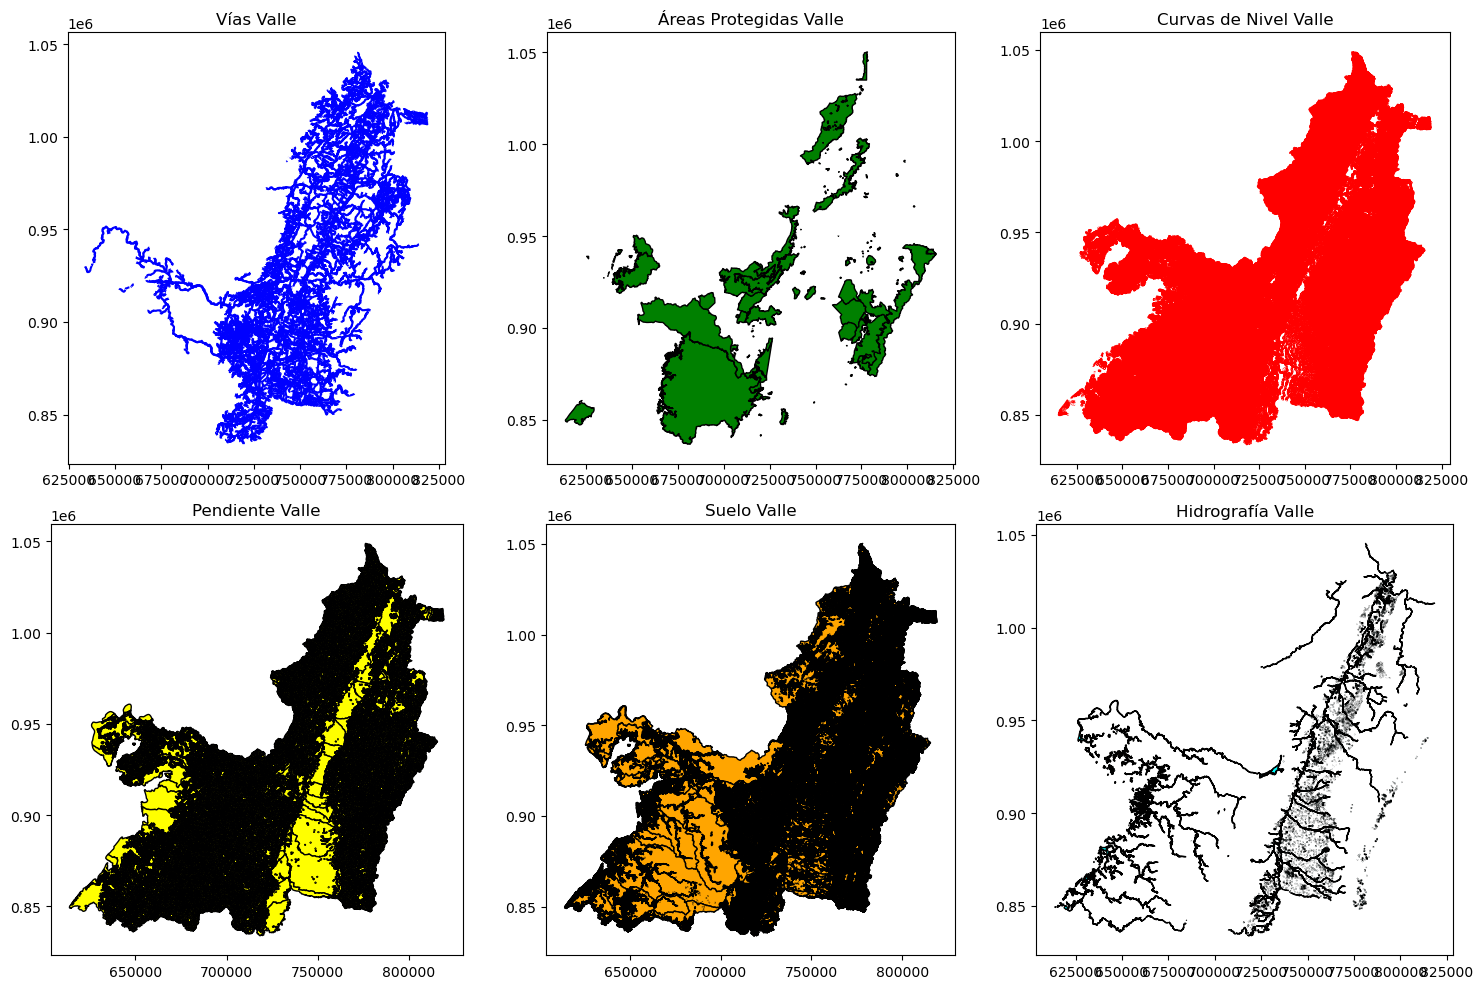

In [13]:
# Visualización de cada capa
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  

# vias_valle
vias_valle.plot(ax=axes[0, 0], color='blue', edgecolor='black')
axes[0, 0].set_title('Vías Valle')

# protegidas_valle
protegidas_valle.plot(ax=axes[0, 1], color='green', edgecolor='black')
axes[0, 1].set_title('Áreas Protegidas Valle')

# curvas_valle
curvas_valle.plot(ax=axes[0, 2], color='red', edgecolor='black')
axes[0, 2].set_title('Curvas de Nivel Valle')

# pendiente_valle
pendiente_valle.plot(ax=axes[1, 0], color='yellow', edgecolor='black')
axes[1, 0].set_title('Pendiente Valle')

# suelo_valle
suelo_valle.plot(ax=axes[1, 1], color='orange', edgecolor='black')
axes[1, 1].set_title('Suelo Valle')

#hidro_valle
hidro_valle.plot(ax=axes[1, 2], color='cyan', edgecolor='black')
axes[1, 2].set_title('Hidrografía Valle')

# Ajustar el layout
plt.tight_layout()
plt.show()

### Análisis preliminar de las capas visualizadas

La visualización gráfica de las seis capas temáticas evidencia una correcta superposición espacial en el área de estudio correspondiente al Valle del Cauca. 

A continuación, se describen observaciones clave para cada una:

- **Vías (azul):** La red vial se encuentra bien distribuida, con mayor densidad en la zona centro-norte del departamento. Esto podría representar una mayor presión antrópica sobre los ecosistemas cercanos.

- **Áreas protegidas (verde):** Las zonas protegidas están mayormente concentradas en la región central y suroriental del Valle del Cauca. Estas áreas serán fundamentales como zonas prioritarias para conservación.

- **Curvas de nivel (rojo):** Las curvas cubren homogéneamente el territorio, lo que garantiza una adecuada base para generar el modelo de pendientes. La densidad indica variabilidad topográfica relevante.

- **Pendientes (amarillo):** Se observan gradientes altitudinales más marcados hacia el oeste (cordillera Occidental) y este (cordillera Central), con zonas más planas en el centro y norte del valle geográfico.

- **Suelo (naranja):** La distribución del uso y cobertura del suelo es heterogénea. Se aprecia una importante cobertura natural en zonas altas, mientras que las tierras bajas están más transformadas (agrícolas o urbanas).

- **Hidrografía (cian):** La red hidrográfica muestra una alta densidad en zonas montañosas y una dispersión hacia el valle central, lo cual es clave para identificar áreas estratégicas de conectividad ecológica y corredores ribereños.